In [ ]:
#Make sure that you have all these libaries available to run the code successfully
# !pip install numpy
# !pip install matplotlib
# !pip install pandas
# !pip install sklearn
# !pip install keras
# !pip install tensorflow
!pip install mxnet gluonts ujson
import json
import mxnet as mx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import shutil
from datetime import datetime
from datetime import timedelta
# !pip uninstall pystan -y
# !pip install pystan~=2.14
# !pip install fbprophet
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
from numpy import mean
from numpy import std
# !pip install mxnet gluonts ujson
import torch
import mxnet as mx
from gluonts.mx import DeepAREstimator
from gluonts.mx.trainer import Trainer



from gluonts.mx import DeepAREstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

from gluonts.evaluation import Evaluator
from gluonts.model.predictor import Predictor
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from datetime import datetime, date, time
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

In [ ]:
!unzip /content/data.zip

Archive:  /content/data.zip
replace Binance_ETHUSDT_minute.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
def prepare_crypto_df(file_name):
    crypto_price_df = pd.read_csv(file_name, header=0, index_col=1)
    crypto_price_df = crypto_price_df[['close']]
    crypto_price_df.index.names = ['Date']
    crypto_price_df.columns = ['Count']
    return crypto_price_df

In [ ]:
#loading data
transactions = pd.read_csv('transactions.csv', header=0, index_col=0)
deep_ds = transactions.drop(['Value'], axis=1)
transaction_values = transactions.drop(['Price'], axis=1)
transaction_values.columns = ['Count']
ethprice = prepare_crypto_df('Binance_ETHUSDT_minute.csv')
maticprice = prepare_crypto_df('Binance_MATICUSDT_minute.csv')


In [ ]:
# features
features = []
names = []
features.append(ethprice)
names.append('ethprice')
# features.append(maticprice)
# names.append('maticprice')
features.append(transaction_values)
names.append('transaction_values')
features.append(pd.read_csv('blocks.csv', header=0, index_col=0))
names.append('blocks')
features.append(pd.read_csv('token_transfers.csv', header=0, index_col=0))
names.append('token_transfers')
features.append(pd.read_csv('traces.csv', header=0, index_col=0))
names.append('traces')
features.append(pd.read_csv('logs.csv', header=0, index_col=0))
names.append('logs')


In [ ]:
def normalize_df(df):
    # return (df-df.mean())/df.std()
    return (df-df.min())/(df.max()-df.min())

In [ ]:
ENABLE_FEATURES = False
RUN_MODEL = True
DELTA = 100
AGG = 20
FREQ = str(AGG) + 'min'

In [ ]:
deep_ds=deep_ds.sort_index()
deep_ds.index = pd.to_datetime(deep_ds.index)
deep_ds = deep_ds.groupby(pd.Grouper(level='Date', freq=FREQ)).mean()

In [ ]:
# use half of deep_ds for training and an extra 20% for validation
mid = len(deep_ds)//2
train_end = deep_ds.index[-mid -1]
train_ds = deep_ds[:train_end]
test_cnt = int(0.25*mid)
test_start = deep_ds.index[-mid]
test_ds = deep_ds[mid:mid + test_cnt]
test_end = test_ds.index[-1]

# end = deep_ds.index[-1]
# test_cnt = int(0.2*deep_ds.shape[0])
# test_start = deep_ds.shape[0] - test_cnt

# train_ds = deep_ds[:deep_ds.index[test_start]]

# start = deep_ds.index[deep_ds.shape[0] - test_cnt + 1]
# end = deep_ds.index[-1] - timedelta(minutes=DELTA*AGG)
# test_ds = deep_ds[deep_ds.index[deep_ds.shape[0] - test_cnt + 1]:end]

len(deep_ds),mid,test_cnt,mid,len(train_ds),len(test_ds),train_end,test_start,test_end

(20952,
 10476,
 2619,
 10476,
 10476,
 2619,
 Timestamp('2021-05-26 11:40:00', freq='20T'),
 Timestamp('2021-05-26 12:00:00', freq='20T'),
 Timestamp('2021-07-01 20:40:00', freq='20T'))

In [ ]:
train_features = []
test_features = []

def fill_feature(reference_ds, feature):
    for date_entry in reference_ds.index:
        if not date_entry in feature.index:
            feature.loc[date_entry] = 0

for i in range(len(features)):
    features[i]=features[i].sort_index()
    features[i].index = pd.to_datetime(features[i].index)
    features[i] = features[i][deep_ds.index[0]:deep_ds.index[-1]]
    if features[i].shape[0] != deep_ds.shape[0]:
        fill_feature(deep_ds, features[i])

    features[i] = features[i].groupby(pd.Grouper(level='Date', freq=FREQ)).mean()
    features[i] = features[i]["Count"]
    features[i] = normalize_df(features[i])
    # train_features.append(features[i][:deep_ds.index[test_start]])
    # test_features.append(features[i][features[i].index[deep_ds.shape[0] - test_cnt + 1]:end])
    train_features.append(features[i][:train_end])
    test_features.append(features[i][test_start:test_end])

    print(len(train_features[i]),len(test_features[i]),train_features[i].index[0], train_features[i].index[-1],test_features[i].index[0], test_features[i].index[-1])


10476 2619 2021-01-01 00:00:00 2021-05-26 11:40:00 2021-05-26 12:00:00 2021-07-01 20:40:00
10476 2619 2021-01-01 00:00:00 2021-05-26 11:40:00 2021-05-26 12:00:00 2021-07-01 20:40:00
10476 2619 2021-01-01 00:00:00 2021-05-26 11:40:00 2021-05-26 12:00:00 2021-07-01 20:40:00
10476 2619 2021-01-01 00:00:00 2021-05-26 11:40:00 2021-05-26 12:00:00 2021-07-01 20:40:00
10476 2619 2021-01-01 00:00:00 2021-05-26 11:40:00 2021-05-26 12:00:00 2021-07-01 20:40:00
10476 2619 2021-01-01 00:00:00 2021-05-26 11:40:00 2021-05-26 12:00:00 2021-07-01 20:40:00


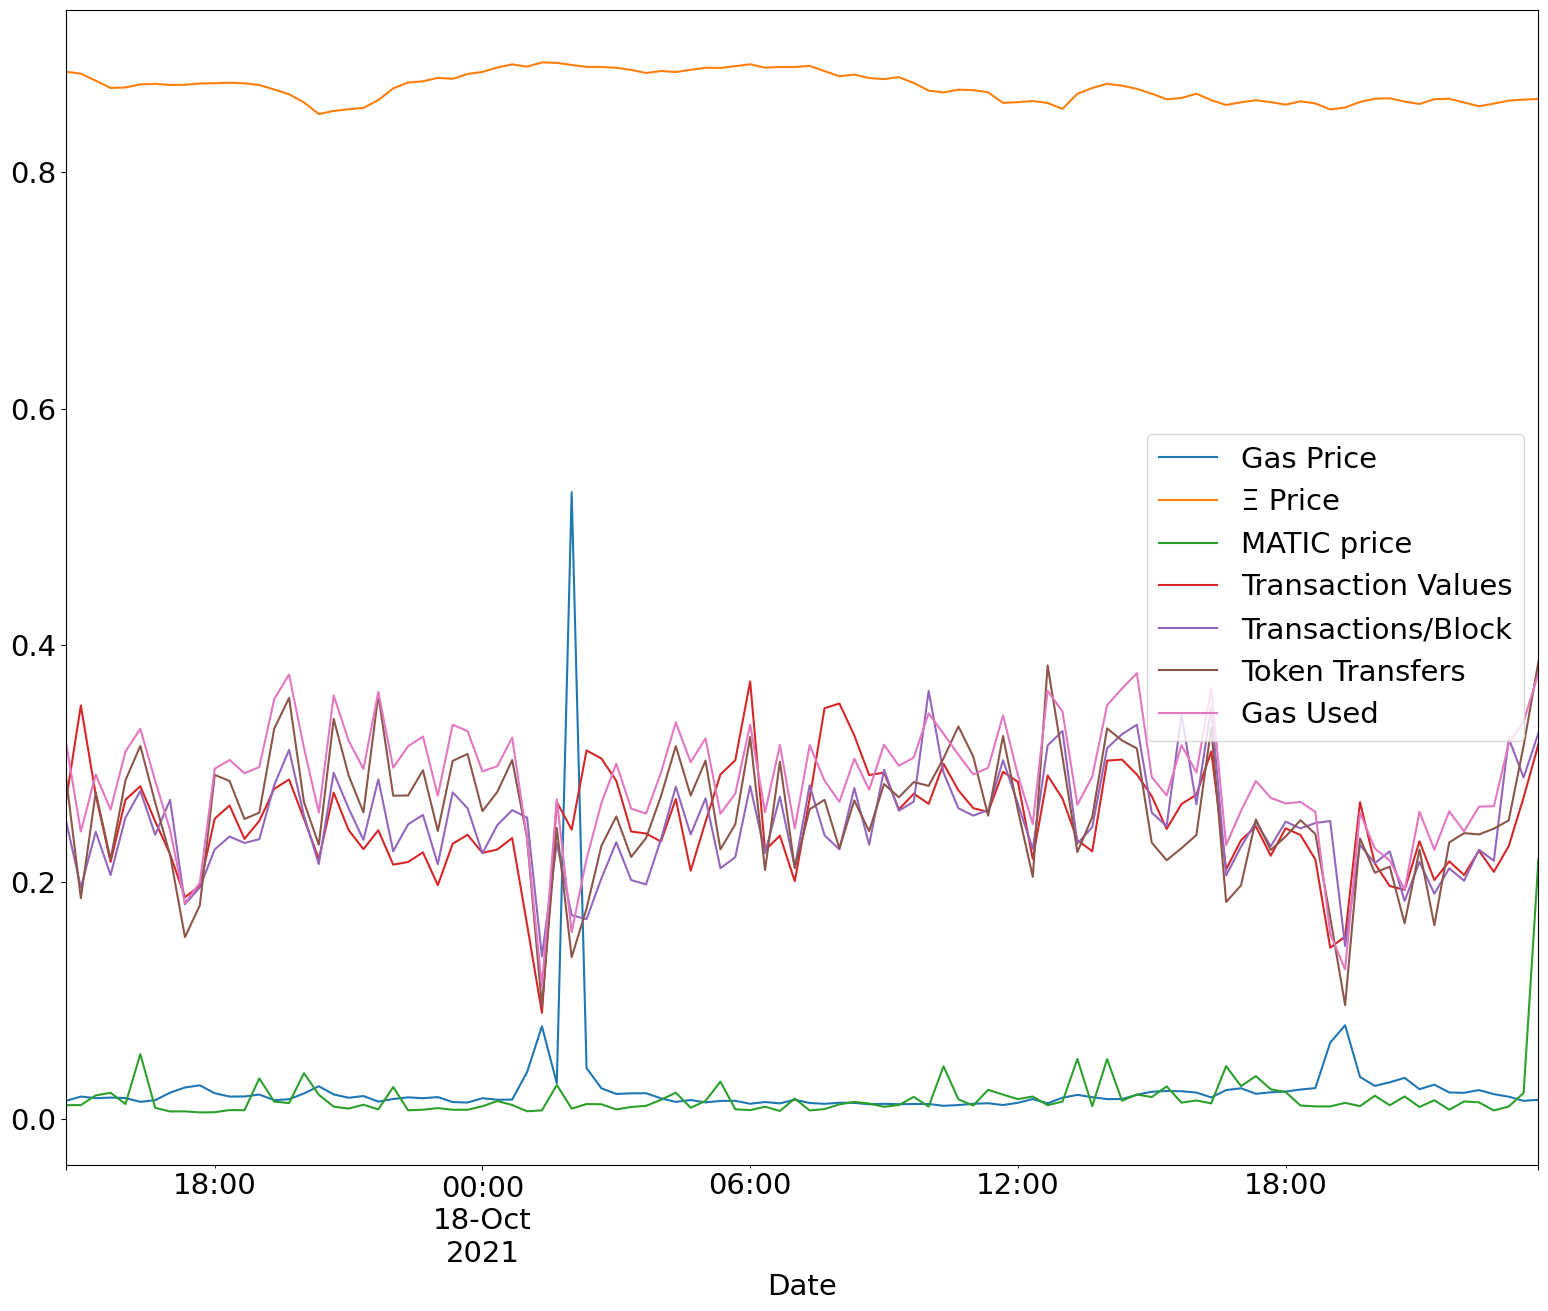

In [ ]:
RANGE = DELTA
column_names = ['Gas Price', 'Ξ Price', 'MATIC price', 'Transaction Values', 'Transactions/Block', 'Token Transfers', 'Gas Used']

fig, ax = plt.subplots(1, 1, figsize=(19, 15))
ax.tick_params(axis='both', which='both', labelsize=21)
ax.set_xlabel("Date/Time", fontsize=21)
ns = normalize_df(deep_ds)
correlation_df = pd.DataFrame(ns[-RANGE:])
correlation_df.columns = [column_names[0]]
ns[-RANGE:].plot(ax=ax)
for i in range(len(features)):
    features[i][-RANGE:].plot(ax=ax)
    correlation_df[column_names[i + 1]] = features[i][-RANGE:]

# fig.suptitle('Normalized Feature Values', fontsize=20)

plt.legend(column_names, loc="best", fontsize=21)
plt.show()


In [ ]:
df_corr = correlation_df.corr()
df_corr.to_latex('corr.tex', float_format='%.2f')
df_corr

,Gas Price,Ξ Price,MATIC price,Transaction Values,Transactions/Block,Token Transfers,Gas Used
Gas Price,1.000000,0.117366,-0.057609,-0.142713,-0.285073,-0.363088,-0.403029
Ξ Price,0.117366,1.000000,-0.168876,0.180030,-0.188479,-0.022928,-0.030507
MATIC price,-0.057609,-0.168876,1.000000,0.188399,0.204463,0.236684,0.207032
Transaction Values,-0.142713,0.180030,0.188399,1.000000,0.480255,0.550110,0.610347
Transactions/Block,-0.285073,-0.188479,0.204463,0.480255,1.000000,0.786500,0.842638
Token Transfers,-0.363088,-0.022928,0.236684,0.550110,0.786500,1.000000,0.940229
Gas Used,-0.403029,-0.030507,0.207032,0.610347,0.842638,0.940229,1.000000


<ipython-input-157-be9ff122028a>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([coln] + coln, fontsize=21)
<ipython-input-157-be9ff122028a>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([coln] + coln, fontsize=21)


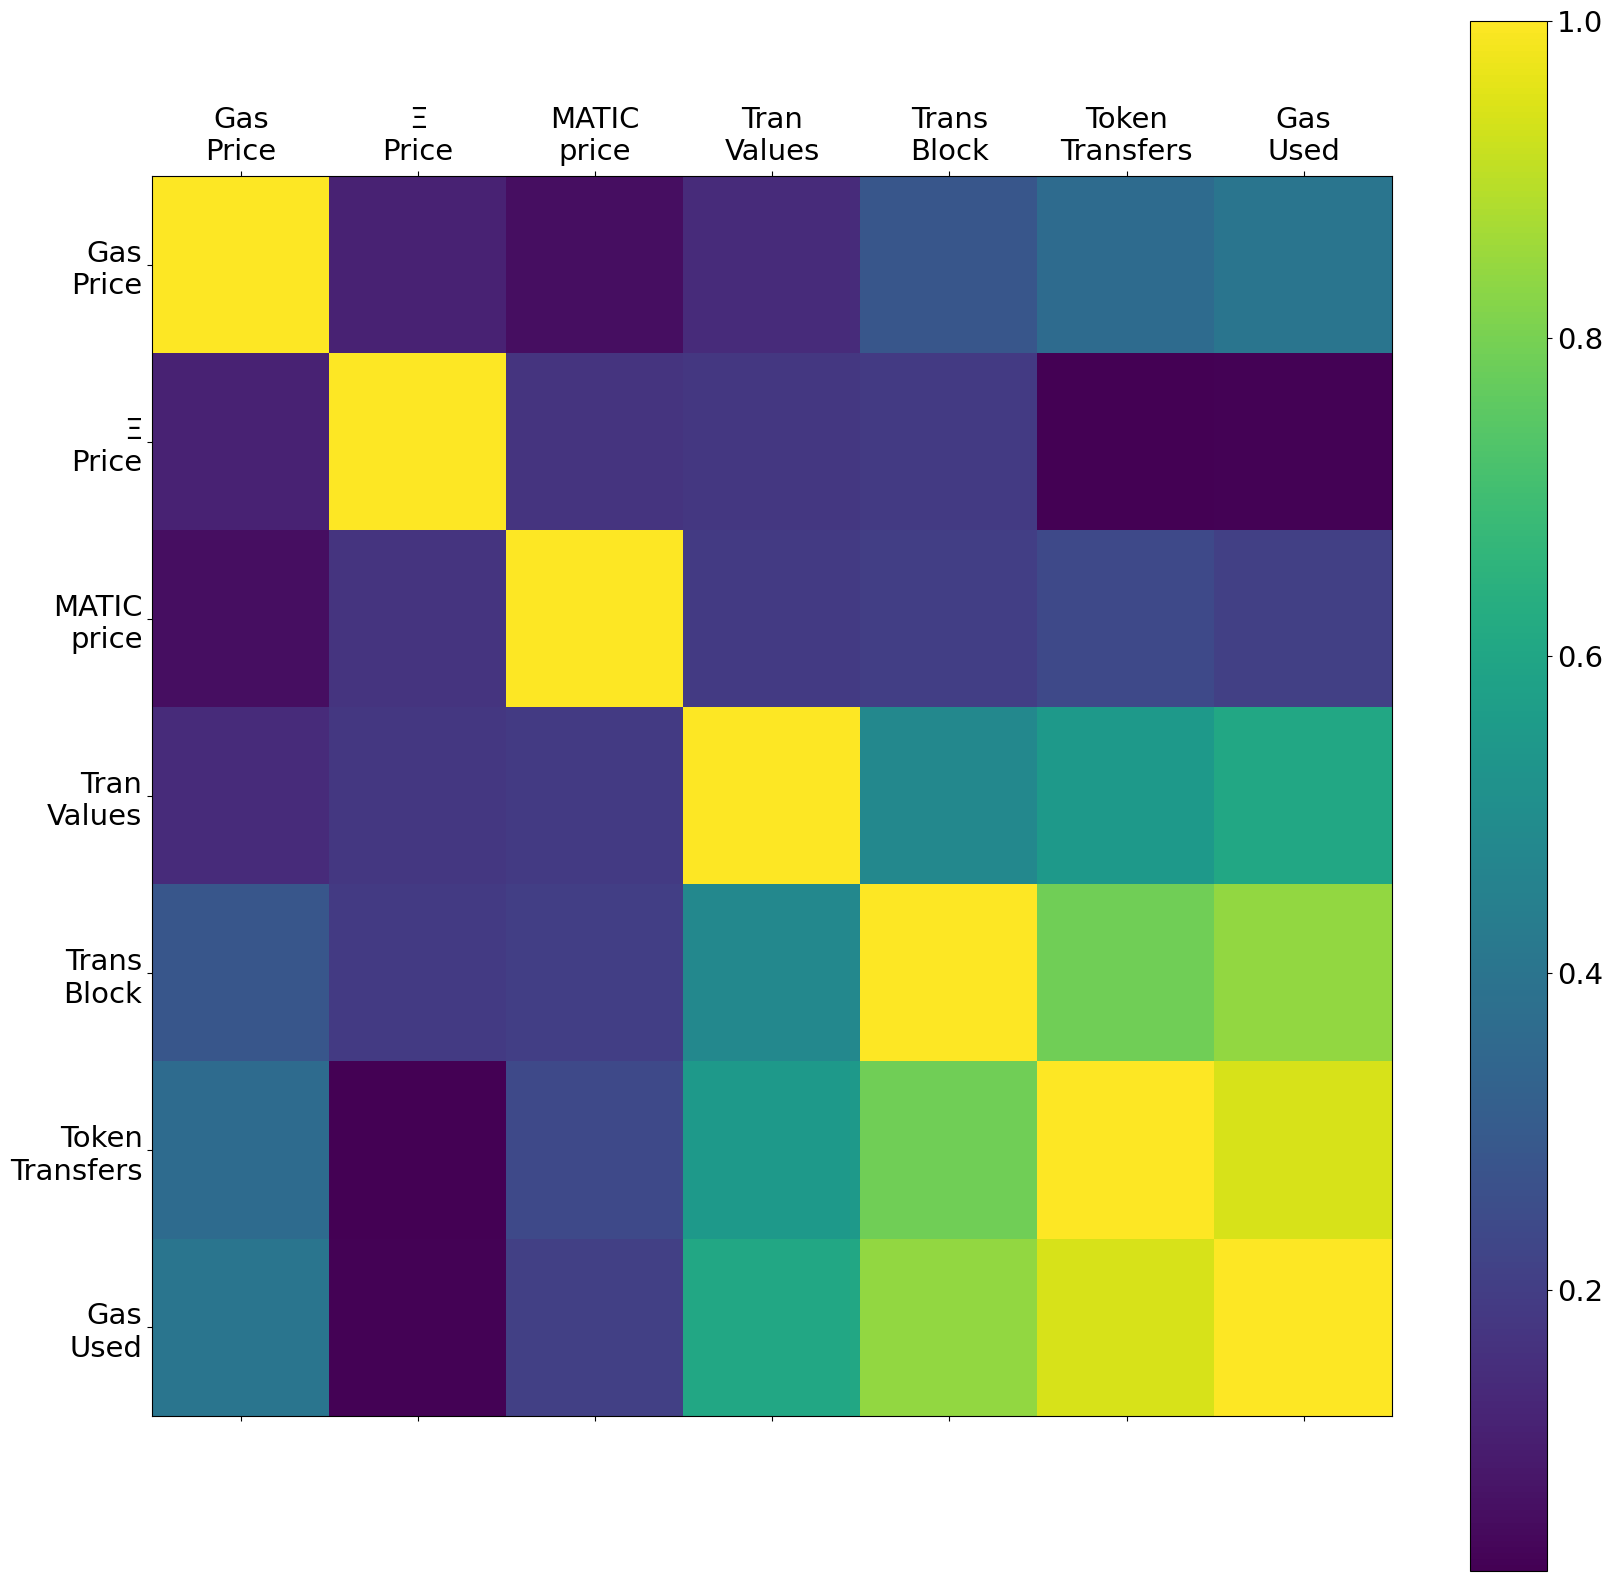

In [ ]:
plt.figure(figsize=(20,20))
coln = [x.replace(" ", "\n").replace("/", "\n").replace("Transaction", "Tran").replace("Transactions", "Trans") for x in column_names]
cax = plt.matshow(df_corr.abs(), fignum=1)
ax = plt.gca()
ax.set_xticklabels([coln] + coln, fontsize=21)
ax.set_yticklabels([coln] + coln, fontsize=21)
cbar = plt.colorbar(cax)
cbar.ax.tick_params(labelsize=21)
plt.show()


In [ ]:
dyn_features = [feature for feature in train_features]

training_data = ListDataset(
    [{"start": deep_ds.index[0], "target": train_ds['Price']
    ,'feat_dynamic_real': dyn_features
    }],
    freq = FREQ
)

In [ ]:
feature_cnt = len(features) if ENABLE_FEATURES else 0
feature_cnt

0

In [ ]:
model_path = "./pred_{}_{}_{}/".format(DELTA, AGG, feature_cnt)

if RUN_MODEL:
    callbacks = [
        LearningRateReduction(objective="min",
                            patience=5,
                            base_lr=2e-4,
                            decay_factor=0.2,
                            ),
        ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
    ]

    estimator = DeepAREstimator(
        freq=FREQ,
        prediction_length=DELTA,
        context_length=2*DELTA,
        num_layers = 4,
        num_cells = 40,
        use_feat_dynamic_real = ENABLE_FEATURES,
        cell_type='gru',
        distr_output=StudentTOutput(),
        dropout_rate=0.01,
        trainer=Trainer(#ctx = mx.context.gpu(),
                        epochs=5,

                        callbacks=callbacks))

    predictor = estimator.train(training_data)
    if os.path.exists(model_path):
        shutil.rmtree(model_path)
    os.mkdir( model_path)
    predictor.serialize(Path(model_path))
else:
    predictor = Predictor.deserialize(Path(model_path))

100%|██████████| 50/50 [01:10<00:00,  1.41s/it, epoch=5/5, avg_epoch_loss=25.4]


In [ ]:
i = 0

In [ ]:
end_date = deep_ds.index[-1 - i*10*DELTA]
# end_date = datetime.combine(date(2021, 10, 17), time(6,0))
start_date = end_date - timedelta(10*DELTA)
test_ds = deep_ds[start_date:end_date]['Price']
dyn_features = [feature[start_date:end_date] for feature in features]
start_date,end_date

(Timestamp('2019-01-22 23:40:00', freq='20T'),
 Timestamp('2021-10-18 23:40:00', freq='20T'))

In [ ]:
i += 1
i

1

In [ ]:
test_data = ListDataset(
    [{"start": test_ds.index[0], "target": test_ds
    ,'feat_dynamic_real': dyn_features
    }],
    freq = FREQ
)

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

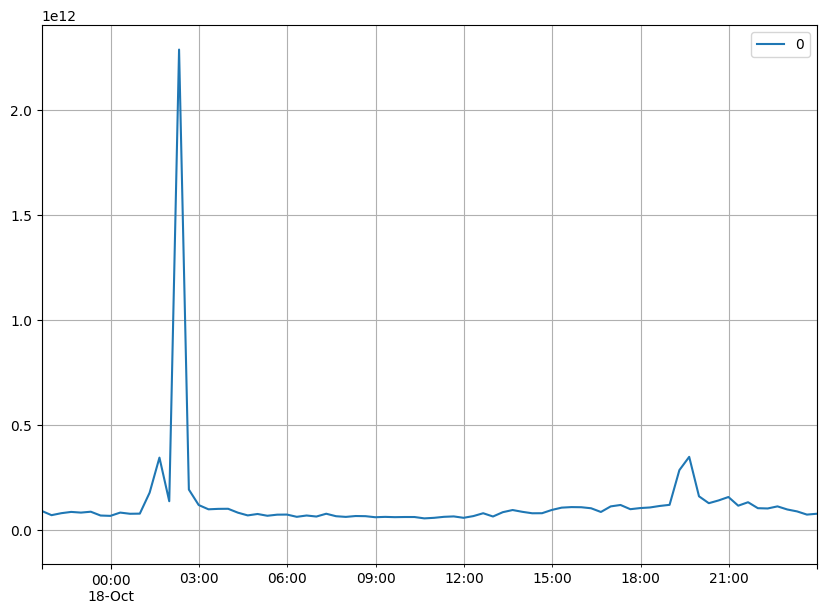

In [ ]:
image_file = "pred_{}_{}_{}_{}.jpg".format(end_date, DELTA, AGG, feature_cnt)

def plot_prob_forecasts(ts_entry, forecast_entry, image_file):
    plot_length = 80
    prediction_intervals = (50.0, 95.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(color='g')

    # forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    # plt.legend(legend, loc="upper left")
    plt.savefig(image_file, dpi=150, bbox_inches='tight')
    plt.show()


plot_prob_forecasts(tss[0], forecasts[0], image_file)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
hvplot.extension('bokeh')

eth_price_prediction_lstm_df.hvplot.line(title = "actual eth price vs. predicted eth prices with lstm").opts(width = 800)

In [ ]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9], ignore_invalid_values=True)
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=1)


Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


In [ ]:
from gluonts.evaluation  import  Evaluator
evaluator= Evaluator(quantiles=[0.1,0.5,0.9])
agg_metrics,item_metrics = evaluator(iter(tss), iter(forecasts), num_series=1)

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


In [ ]:
item_metrics

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,num_masked_target_values,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,2021-10-18 20:40,1.006867e+21,1.186119e+12,4.300088e+12,1.075022e+11,4.125055e+10,0.71885,0.302073,0.378911,0.0,0.275836,5.03255,3.687516e+11,0.05,1.186119e+12,0.175,7.382024e+11,0.45


In [ ]:

csv_file = "pred_{}_{}_{}_{}.json".format(end_date, DELTA, AGG, feature_cnt)
with open(csv_file, 'w') as writer:
    writer.write(json.dumps(agg_metrics, indent=4))


In [ ]:

print('Last run:', image_file, csv_file)

Last run: pred_2021-10-18 23:55:00_40_5_0.jpg pred_2021-10-18 23:55:00_40_5_0.json


In [2]:
import pickle


In [ ]:
filename = 'deepar_eth.sav'
pickle.dump(forecast_it, open(filename, 'wb'))